In [1]:
!python -m spacy download pt_core_news_sm
!pip install googletrans==4.0.0-rc1
!pip install enelvo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.2 MB/s eta 0

In [2]:
from google.colab import drive
from googletrans import Translator
from enelvo.normaliser import Normaliser
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Concatenate, Input, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
import re
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import nltk
import time

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Pré-processamento

## 0) Base de Dados

In [4]:
norm = Normaliser(tokenizer='readable')
chats_clients = pd.read_csv('/content/drive/Shareddrives/grupo3moshi/chats_clients.csv')
chats_clients.head()

,No,Intencao,Pergunta,Resposta
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...


In [5]:
chats_clients.fillna('erro ao processar a pergunta', inplace=True)

In [6]:
nlp_pt = spacy.load("pt_core_news_sm")

In [7]:
def correct_grammar(text):
  return norm.normalise(text)

## 1) Word2Vec

O processo de Word2Vec é uma técnica de aprendizado de máquina com o objetivo de vetorizar palavras almejando preservar o contexto, convertendo o resultado para a forma numérica, para que os dados possam ser utilizados em modelos de aprendizado de máquina.

O Word2Vec pode possuir 2 arquiteturas, sendo elas:

- Skip-Gram: rede tenta prever as palavras de contexto ao redor de uma palavra central
- CBOW: rede tenta prever a palavra central com base no contexto ao redor da palavra central.

Para fins de comparação, ambas as técnicas serão abordadas no código a seguir:

### 1.1) Skip-Gram

In [8]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Tokenizando as colunas
chats_clients['Pergunta_tokens'] = chats_clients['Pergunta'].apply(lambda x: word_tokenize(x.lower()))
chats_clients['Resposta_tokens'] = chats_clients['Resposta'].apply(lambda x: word_tokenize(x.lower()))

# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_skip = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model = Word2Vec(sentences_skip, vector_size=100, window=5, min_count=1, sg=1)  #sg=1 para Skip-Gram

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 1.2) Resultados Obtidos

In [9]:
# Acessando o vetor de uma palavra
vector_dia_skip = model.wv['dia']
print(vector_dia_skip)

[-1.64622739e-01  1.15440972e-01 -1.81751072e-01 -1.24593154e-01
  1.66266814e-01 -1.83720991e-01  2.96449721e-01  4.11734492e-01
  8.51575062e-02 -3.04585129e-01  3.44001763e-02 -4.65588123e-02
  5.58775999e-02 -1.81536824e-01  1.12949207e-01 -2.15742979e-02
  7.92717934e-02 -3.20201702e-02 -1.09620914e-01 -2.56403238e-01
  2.16105163e-01 -4.43398841e-02  1.79219022e-01 -1.43739143e-02
 -1.54390439e-01  4.91979532e-02 -2.55494565e-01 -4.56426628e-02
  5.66938482e-02 -4.85935174e-02  1.08865626e-01  1.76067695e-01
 -2.19490364e-01 -8.76718014e-03  4.54726256e-02  2.46649191e-01
 -1.64822061e-02  6.43643513e-02 -1.64749056e-01 -1.93129972e-01
  3.57611716e-01 -9.13158879e-02 -1.07616171e-01  8.10310021e-02
  3.46592903e-01  1.94809273e-01 -3.66627544e-01 -1.28145158e-01
  1.33090988e-01  1.08326115e-01  1.59867361e-01 -2.60351717e-01
  8.12974125e-02 -1.71100393e-01 -1.13501765e-01  1.16747223e-01
  2.48192772e-02  1.06270306e-01 -6.80514425e-02  6.21831901e-02
  1.42097458e-01 -5.13500

In [10]:
# Encontrando palavras similares
similar_words_dia_skip = model.wv.most_similar('dia')
print(similar_words_dia_skip)

[('bom', 0.9671410322189331), ('noite', 0.9268924593925476), ('olá', 0.9253766536712646), ('fiz', 0.9146114587783813), ('!', 0.9093514084815979), ('gostaria', 0.9062446355819702), ('tudo', 0.9046801328659058), ('um', 0.9041330814361572), ('uma', 0.9040729999542236), ('tarde', 0.9016468524932861)]


In [11]:
# Encontrando palavras similares
similar_words_bom_skip = model.wv.most_similar('bom')
print(similar_words_bom_skip)

[('dia', 0.9671408534049988), ('olá', 0.9397634863853455), ('noite', 0.9386446475982666), ('fiz', 0.9286245107650757), ('uma', 0.9234089255332947), ('!', 0.9189625382423401), ('tudo', 0.9170261025428772), ('um', 0.9157498478889465), ('eu', 0.9153373837471008), ('gostaria', 0.9127625823020935)]


In [12]:
# Encontrando palavras similares
similar_words_dinheiro_skip = model.wv.most_similar('dinheiro')
print(similar_words_dinheiro_skip)

[('tempo', 0.9830349087715149), ('japão', 0.9745590686798096), ('pra', 0.9682563543319702), ('levará', 0.9639114737510681), ('enviar', 0.956784725189209), ('quanto', 0.9557215571403503), ('mandar', 0.9547973871231079), ('?', 0.9486173391342163), ('eu', 0.9453557133674622), ('preciso', 0.9431247115135193)]


In [13]:
# Encontrando palavras similares
similar_words_pix_skip = model.wv.most_similar('pix')
print(similar_words_pix_skip)

[('via', 0.9925075173377991), ('feitos', 0.975697934627533), ('pagamentos', 0.9717152714729309), ('sendo', 0.9552972912788391), ('estão', 0.950811505317688), ('pagas', 0.9302712678909302), ('dentro', 0.9045297503471375), ('são', 0.8899891376495361), ('realizadas', 0.8789695501327515), ('geralmente', 0.8641633987426758)]


### 2.1) CBOW

In [14]:
# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_CBOW = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model_cbow = Word2Vec(sentences_CBOW, vector_size=100, window=5, min_count=1, sg=0)  #sg=0 para CBOW

### 2.2) Resultados Obtidos

In [15]:
# Acessando o vetor de uma palavra
vector_dia_cbow = model_cbow.wv['dia']
print(vector_dia_cbow)

[-1.9465457e-01  3.9444774e-01 -1.0076248e-04  8.6036623e-03
  1.9202754e-01 -7.0496631e-01  3.4607971e-01  9.5025665e-01
 -2.0617120e-01 -3.4302637e-01 -1.7820613e-01 -6.1194527e-01
 -1.1548246e-03  3.2815751e-02  2.4452914e-01 -2.5529674e-01
  1.6459058e-01 -4.4233435e-01 -1.2667616e-01 -8.1143713e-01
  5.2685454e-02  1.1638185e-01  2.4105434e-01 -7.6337710e-02
 -2.0055526e-01  5.1670261e-02 -3.0120865e-01 -2.5156251e-01
 -3.5105100e-01  1.9816074e-01  4.4377333e-01  2.2410788e-03
  2.1197294e-01 -3.8635391e-01 -3.3647662e-01  6.0935497e-01
 -3.1099506e-02 -2.2042233e-01 -1.6382366e-01 -7.0042896e-01
  3.0725983e-01 -3.4725896e-01 -2.7228594e-01  3.4558993e-02
  3.2945758e-01 -4.4114679e-02 -3.6729431e-01 -1.4409992e-01
  2.0872109e-01  2.0288841e-01  2.7766517e-01 -3.9603171e-01
  7.7071980e-02 -1.1038563e-01 -2.7728769e-01  7.0092581e-02
  1.9555019e-01 -9.1943063e-02 -3.8674784e-01  1.6873170e-01
  1.6883766e-02 -5.0237302e-02  1.3320647e-01 -1.7142835e-01
 -5.5134958e-01  3.84611

In [16]:
# Encontrando palavras similares
similar_words_dia_cbow = model_cbow.wv.most_similar('dia')
print(similar_words_dia_cbow)

[('quanto', 0.9993242025375366), ('em', 0.9992724657058716), ('eu', 0.9992443919181824), ('ienes', 0.9992319941520691), ('uma', 0.9992190599441528), ('!', 0.9992045760154724), ('meu', 0.9991795420646667), ('ser', 0.9991767406463623), ('não', 0.9991723895072937), ('um', 0.9991705417633057)]


In [17]:
# Encontrando palavras similares
similar_words_bom_cbow = model_cbow.wv.most_similar('bom')
print(similar_words_bom_cbow)

[('uma', 0.9993357062339783), ('meu', 0.9993175268173218), ('está', 0.999310314655304), ('um', 0.9992641806602478), ('eu', 0.9992433190345764), ('em', 0.9992350339889526), ('que', 0.9992213845252991), ('!', 0.9991458058357239), ('estou', 0.9991403818130493), ('mil', 0.9991403818130493)]


In [18]:
# Encontrando palavras similares
similar_words_dinheiro_cbow = model_cbow.wv.most_similar('dinheiro')
print(similar_words_dinheiro_cbow)

[('?', 0.9995037317276001), ('enviar', 0.9994708895683289), ('pra', 0.9993816614151001), ('do', 0.9993751645088196), ('como', 0.9993569254875183), ('beneficiário', 0.9993556141853333), ('um', 0.9993165731430054), ('ienes', 0.9993041157722473), ('hoje', 0.9992889165878296), ('eu', 0.9992575645446777)]


In [19]:
# Encontrando palavras similares
similar_words_pix_cbow = model_cbow.wv.most_similar('pix')
print(similar_words_pix_cbow)

[('via', 0.9991350769996643), ('dos', 0.9989699125289917), ('pagamentos', 0.9989665746688843), ('as', 0.9989446997642517), ('estão', 0.9989253878593445), ('pagas', 0.9987663626670837), ('saldo', 0.9987465143203735), ('são', 0.9987286925315857), ('~', 0.9987121820449829), ('sendo', 0.9987021088600159)]


### 3.1) Word Embedding


Dessa forma, é fundamental gerar os embedding das colunas para que futuros modelos de aprendizado de máquina possam compreender e utilizar os dados de cada frase. Para tal, será utilizado uma média dos vetores de cada frase, desenvolvido a seguir, utilizando a abordagem CBOW (padrão):


In [20]:
import numpy as np

# Função para gerar o embedding médio de uma frase
def get_sentence_embedding(tokens, model):
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

### 3.2) Resultados Obtidos

In [21]:
# Aplicando a função para gerar os embeddings e salvando nas novas colunas
chats_clients['Pergunta_embedding'] = chats_clients['Pergunta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))
chats_clients['Resposta_embedding'] = chats_clients['Resposta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))

In [22]:
chats_clients['Pergunta_embedding'].head()

,Pergunta_embedding
0,"[-0.14932206, 0.2607703, 0.008743056, 0.022468..."
1,"[-0.22554982, 0.3817192, 0.010032334, 0.020979..."
2,"[-0.20845656, 0.37725765, 0.00442956, 0.029480..."
3,"[-0.17693976, 0.31560788, 0.0011354734, 0.0191..."
4,"[-0.14822283, 0.2717012, 0.0104172835, 0.02846..."


In [23]:
chats_clients['Resposta_embedding'].head()

,Resposta_embedding
0,"[-0.13887833, 0.26058662, 0.0055258046, 0.0242..."
1,"[-0.14074458, 0.36585078, 0.0003020196, 0.0599..."
2,"[-0.1527312, 0.32566625, 0.002135682, 0.030221..."
3,"[-0.13526401, 0.27975017, 0.015481441, 0.05025..."
4,"[-0.13526401, 0.27975017, 0.015481441, 0.05025..."


## 2) Base de Dados Final

In [24]:
chats_clients

,No,Intencao,Pergunta,Resposta,Pergunta_tokens,Resposta_tokens,Pergunta_embedding,Resposta_embedding
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d...","[boa, dia.tudo, bem, ?, eu, gostaria, de, sabe...","[bom, dia, !, sim, ,, o, sr, pode, utilizar, o...","[-0.14932206, 0.2607703, 0.008743056, 0.022468...","[-0.13887833, 0.26058662, 0.0055258046, 0.0242..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f...","[como, enviar, dinheiro, do, japão, ?]","[para, se, inscrever, no, serviço, de, remessa...","[-0.22554982, 0.3817192, 0.010032334, 0.020979...","[-0.14074458, 0.36585078, 0.0003020196, 0.0599..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ...","[quanto, tempo, levará, para, o, beneficiário,...","[via, de, regra, ,, as, remessas, serão, pagas...","[-0.20845656, 0.37725765, 0.00442956, 0.029480...","[-0.1527312, 0.32566625, 0.002135682, 0.030221..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...,"[boa, tarde, acabei, de, fazer, a, transferênc...","[iremos, processar, a, sua, solicitacao, ., mu...","[-0.17693976, 0.31560788, 0.0011354734, 0.0191...","[-0.13526401, 0.27975017, 0.015481441, 0.05025..."
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...,"[poderia, fazer, a, remessa, de, 22yenes, para...","[iremos, processar, a, sua, solicitacao, ., mu...","[-0.14822283, 0.2717012, 0.0104172835, 0.02846...","[-0.13526401, 0.27975017, 0.015481441, 0.05025..."
...,...,...,...,...,...,...,...,...
500,501,Atualizacao de dados cadastrais,Boa tarde como faço para fazer a mudança de en...,A senhora pode trocar pelo próprio app da Bras...,"[boa, tarde, como, faço, para, fazer, a, mudan...","[a, senhora, pode, trocar, pelo, próprio, app,...","[-0.19843921, 0.34748495, 0.0044574123, 0.0242...","[-0.15314521, 0.31077015, -0.0004359449, 0.024..."
501,502,Tempo de entrega do cartao,Bom dia\nConsegui fazer depósito sem o cartão ...,Boa noite\nO sr solicitou dia 28. Será entregu...,"[bom, dia, consegui, fazer, depósito, sem, o, ...","[boa, noite, o, sr, solicitou, dia, 28., será,...","[-0.1641251, 0.2997973, 0.0031412304, 0.026119...","[-0.1312652, 0.24709645, 0.006347921, 0.023047..."
502,503,Cancelamento,"Boa noite,a beneficiária me avisou que a conta...","Sim, podemos cancelar\nO valor voltará no seu ...","[boa, noite, ,, a, beneficiária, me, avisou, q...","[sim, ,, podemos, cancelar, o, valor, voltará,...","[-0.164907, 0.31152534, 0.006429464, 0.0284910...","[-0.15169097, 0.3065714, 0.0016985825, 0.02754..."
503,504,Reembolso,"Boa noite\nEu fiz um depósito errado, era pra ...",É possível solicitar o reembolso diretamente d...,"[boa, noite, eu, fiz, um, depósito, errado, ,,...","[é, possível, solicitar, o, reembolso, diretam...","[-0.19328952, 0.35715032, 0.0047362344, 0.0268...","[-0.15356483, 0.28676006, 0.015026205, 0.03816..."


In [25]:
class IntentClassifier:
    def __init__(self, epochs=500, batch_size=16, test_size=0.4, validation_split=0.4, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())
        response_embeddings = np.array(chats_clients['Resposta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        combined_embeddings = np.stack((answer_embeddings, response_embeddings), axis=1)
        X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        self.model.add(Dropout(0.5))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train(self, X_train, X_test, y_train, y_test):
        # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                          #  early_stopping,
                           model_checkpoint
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes)

        report_df = pd.DataFrame({
            'Class': self.label_encoder.classes_,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })

        report_df.loc['Average'] = report_df[['Precision', 'Recall', 'F1-Score', 'Support']].mean()
        report_df.loc['Average', 'Class'] = 'Average'

        print(report_df)


### Treino e avaliação com CPU

Para rodar o modelo com a CPU basta alocar qualquer máquina do colab, rodar todas as células anteriores e rodar a célula abaixo.

In [27]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
with tf.device('/cpu:0'):
  # Calcula o tempo da cpu
  start_time = time.time()
  classifier.train(X_train, X_test, y_train, y_test)
  y_pred_classes = classifier.predict(X_test)
  # Para o cronômetro e salva o tempo da cpu
  time_cpu = time.time() - start_time

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 2, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 18)                  │             594 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,506 (1.23 MB)

 Trainable params: 323,506 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.1026 - loss: 2.8831 - val_accuracy: 0.0984 - val_loss: 2.8307
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0800 - loss: 2.7754 - val_accuracy: 0.0246 - val_loss: 2.7401
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1056 - loss: 2.6037 - val_accuracy: 0.2459 - val_loss: 2.7438
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2694 - loss: 2.4839 - val_accuracy: 0.2459 - val_loss: 2.7412
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2266 - loss: 2.5689 - val_accuracy: 0.2459 - val_loss: 2.7406
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2265 - loss: 2.4146 - val_accuracy: 0.2459 - val_loss: 2.7471
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2282 - loss: 2.4558 - val_accuracy: 0.2459 - val_loss: 2.6928
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2049 - loss: 2.4590 - val_accuracy: 0

### Treino e avaliação com GPU

Para rodar o modelo com a GPU é necessário alocar uma máquina com GPU, por exemplo a T4 GPU, rodar todas as células anteriores (exceto a de treino com CPU que não é necessária) , e rodar a célula abaixo.

In [28]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
with tf.device('/gpu:0'):
  # Calcula o tempo da gpu
  start_time = time.time()
  classifier.train(X_train, X_test, y_train, y_test)
  y_pred_classes = classifier.predict(X_test)
  # Para o cronômetro e salva o tempo da gpu
  time_gpu = time.time() - start_time

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 2, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 18)                  │             594 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,506 (1.23 MB)

 Trainable params: 323,506 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.0530 - loss: 2.8734 - val_accuracy: 0.1311 - val_loss: 2.8322
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1680 - loss: 2.7257 - val_accuracy: 0.2459 - val_loss: 2.7786
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2542 - loss: 2.4990 - val_accuracy: 0.2459 - val_loss: 2.7947
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2723 - loss: 2.4792 - val_accuracy: 0.2459 - val_loss: 2.7043
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2098 - loss: 2.5011 - val_accuracy: 0.2459 - val_loss: 2.7043
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2180 - loss: 2.4769 - val_accuracy: 0.2459 - val_loss: 2.7292
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2632 - loss: 2.4165 - val_accuracy: 0.2459 - val_loss: 2.6945
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2962 - loss: 2.3583 - val_accuracy: 0.

### Análise entre CPU e GPU

Para rodar esta análise é preciso rodar o modelo com a CPU e a GPU.

Podemos ver que a GPU foi ligeiramente mais rápida, aproximadamente 39 segundos, ou aproximadamente 28%.

In [29]:
print(f'Tempo de treinamento com CPU: {time_cpu}')
print(f'Tempo de treinamento com GPU: {time_gpu}')

Tempo de treinamento com CPU: 177.96355366706848
Tempo de treinamento com GPU: 138.91867351531982


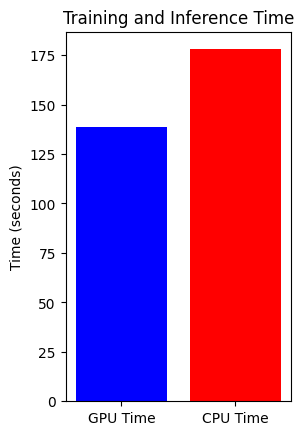

In [31]:
# Plotando o tempo de treinamento e inferência da CPU e GPU
plt.subplot(1, 2, 2)
plt.bar(['GPU Time'], [time_gpu], color=['blue'])
plt.bar(['CPU Time'], [time_cpu], color=['red'])
plt.ylabel('Time (seconds)')
plt.title('Training and Inference Time')

plt.show()

### Matriz de Confusão

A matriz de confusão avalia o desempenho do modelo. Os eixos Y representa as classes verdadeiras (true label) e o eixo x representa as classes previstas (predicted label). Além de indicar a frequência, as cores na matriz representam a intensidade dos valores nas células, ajudando a visualizar a frequência das classificações corretas e incorretas. Quanto mais escuro, mais frequente.

Cada célula na matriz indica o número de vezes que uma classe verdadeira foi prevista como classe específica. Já as células da diagonal principal indicam as instâncias onde o modelo previu corretamente.

#### Interpretação
* A célula (7, 7) tem 33 instâncias, indicando que 33 exemplos da classe 7 foram corretamente classificados como classe 7. Parece ser a classe mais corretamente classificada, com 33 instâncias corretas e poucas confusões com outras classes.

* A célula (9, 9) tem 23 instâncias, indicando que 23 exemplos da classe 9 foram corretamente classificados como classe 9.

* A célula (17, 7) mostra que 9 exemplos da classe 17 foram incorretamente classificados como classe 7.

* A célula (10, 16) mostra que 6 exemplos da classe 10 foram incorretamente classificados como classe 15.

É observado que a classe de índice 17, 16 e 10 mostra uma confusão e que o modelo trabalha bem com as classes 7 e 9. Conclui-se então que as células ao longo da diagonal principal indicam as instâncias onde o modelo previu corretamente a classe e por este motivo se destaca na matriz.

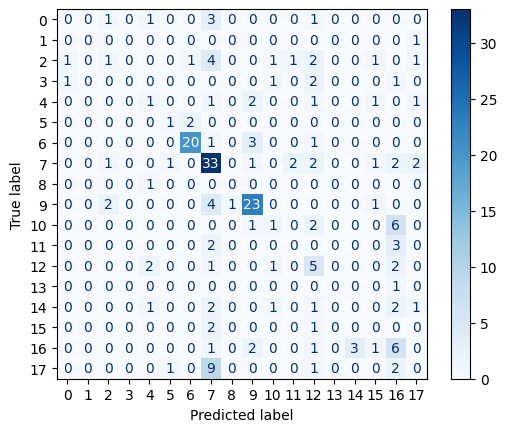

                                        Class  Precision    Recall  F1-Score  \
0                              Acesso a conta   0.000000  0.000000  0.000000   
1             Atualizacao de dados cadastrais   0.000000  0.000000  0.000000   
2                    Cadastro de beneficiario   0.200000  0.076923  0.111111   
3                                Cancelamento   0.000000  0.000000  0.000000   
4                              Como depositar   0.166667  0.142857  0.153846   
5                          Como fazer remessa   0.333333  0.333333  0.333333   
6                           Como se inscrever   0.869565  0.800000  0.833333   
7                 Confirmacao de cambio/taxas   0.523810  0.733333  0.611111   
8                      Envio via Deposit Code   0.000000  0.000000  0.000000   
9        Pedido de envio via metodo "ByPhone"   0.718750  0.741935  0.730159   
10                       Problemas de remessa   0.200000  0.100000  0.133333   
11                                  Reem

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Calcula a matriz de confusão
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

classifier.generate_report(y_test, y_pred_classes)